# HW1_Сравнительный анализ моделей классификации отзывов

**ФИО Студента:** Майер Юрий Алексеевич

**Дата Выполнения:** 20 - 21 сентября 25

-----

## **1. Подготовка данных и EDA**

### **1.1. Загрузка и подготовка библиотек**

> Для начала проверим на каком питоне мы работаем:

In [1]:
!python -V

Python 3.12.4


> Я кодил на своём ПК через VS Code, так что создал `requirements.txt` с подходящими либами:

In [2]:
import os

os.listdir('../')

['.gitignore', '.venv', 'base', 'done', 'nltk_data', 'requirements.txt']

Установим библиотечки в `.venv` на 3.12 питоне, и магия должна заработать 😇

In [1]:
# Основные библиотеки
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
import pickle
from datetime import datetime

# NLP библиотеки
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy3

# Embeddings
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
import gensim.downloader as api

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)

# Визуализация
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud

# Интерпретируемость
import shap
import lime

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

In [ ]:
# Создание структуры папок
folders = ['data', 'models', 'results', 'visualizations', 'reports']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Загрузка ресурсов NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
print("NLTK ресурсы загружены")

# Инициализация морфологического анализатора и стоп-слов
stop_words_ru = set(stopwords.words('russian'))
stop_words_en = set(stopwords.words('english'))

NLTK ресурсы загружены


### **1.2. Загрузка и первичный анализ данных**

Загрузим датасет и проведем базовый анализ, чтобы понять его структуру.

In [4]:
# Загрузка датасета
from datasets import load_dataset
df = load_dataset("d0rj/geo-reviews-dataset-2023")
df = pd.DataFrame(df['train'])

Using the latest cached version of the dataset since d0rj/geo-reviews-dataset-2023 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\user\.cache\huggingface\datasets\d0rj___geo-reviews-dataset-2023\default\0.0.0\02366bc66bd43aa69e707747487ec8f3c22cac84 (last modified on Sat Sep 20 20:32:17 2025).


In [5]:
# ЗАДАНИЕ: Удалите нейтральные отзывы (рейтинг 3) и создайте бинарную целевую переменную 'sentiment'.
# 1 - позитивный отзыв (рейтинг 4, 5)
# 0 - негативный отзыв (рейтинг 1, 2)
# Удалите строки с отсутствующими значениями в 'sentiment'.


# ЗАДАНИЕ: Сбалансируйте классы, чтобы количество позитивных и негативных отзывов было одинаковым.

Уберём нейтральные отзывы - те, что с троечкой

In [6]:
df = df[df['rating'] != 3]

Создадим конлонку sentiment

In [7]:
def make_sentiment(r):
    """Создаём sentiment - бинарную кеолонку для нашего датафрейма"""
    if r in [4, 5]:
        return 1
    elif r in [1, 2]:
        return 0
    else:
        return None

In [8]:
df['sentiment'] = df['rating'].apply(make_sentiment)

In [9]:
df['sentiment'].value_counts()

sentiment
1.0    431675
0.0     46439
Name: count, dtype: int64

Выходит, `None` есть!

In [10]:
assert df.shape[0] == df['sentiment'].value_counts().sum()

AssertionError: 

In [11]:
df = df.dropna(subset=['sentiment'])

Теперь чистенько 😏

In [12]:
assert df.shape[0] == df['sentiment'].value_counts().sum()

Возьмём разные классы, и сбалансируем по минимуму:

> В чатике кто-то писал что можно сделать аугментацию и не ограничивать данные до минимума, и как вариант для прода - интересный. Но звучит сложновато!

In [13]:
count_pos = df[df['sentiment'] == 1].shape[0]
count_neg = df[df['sentiment'] == 0].shape[0]

In [14]:
min_ = min(count_pos, count_neg)

In [15]:
pos_df = df[df['sentiment'] == 1].sample(min_)
neg_df = df[df['sentiment'] == 0].sample(min_)
df = pd.concat([pos_df, neg_df]).sample(frac=1)

In [16]:
df['sentiment'].value_counts()

sentiment
1.0    46439
0.0    46439
Name: count, dtype: int64

Ровненько!

In [17]:
# Вывод базовой информации о датасете
print("Исследовательский анализ данных:")
print(f"\nРазмер датасета: {df.shape}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПропущенные значения:\n{df.isnull().sum()}")

# Распределение классов
class_distribution = df['sentiment'].value_counts()
print("\nРаспределение классов:")
print(f"Позитивные (1): {class_distribution.get(1, 0)} ({class_distribution.get(1, 0)/len(df)*100:.1f}%)")
print(f"Негативные (0): {class_distribution.get(0, 0)} ({class_distribution.get(0, 0)/len(df)*100:.1f}%)")

Исследовательский анализ данных:

Размер датасета: (92878, 6)

Типы данных:
address       object
name_ru       object
rating         int64
rubrics       object
text          object
sentiment    float64
dtype: object

Пропущенные значения:
address        0
name_ru      166
rating         0
rubrics        0
text           0
sentiment      0
dtype: int64

Распределение классов:
Позитивные (1): 46439 (50.0%)
Негативные (0): 46439 (50.0%)


### **1.3. Исследовательский анализ данных (EDA)**

Проведем более глубокий анализ текстовых данных и визуализируем результаты.

In [18]:
# ЗАДАНИЕ: Добавьте в датафрейм столбцы с длиной текста, количеством слов и предложений.
# df['text_length'] = ...
# df['word_count'] = ...
# df['sentence_count'] = ...

`sent_tokenize` получше будет работать с предложеними для нас, так что импортнём её

In [19]:
from nltk.tokenize import sent_tokenize

In [20]:
df['text_length'] = df['text'].apply(len)

In [21]:
tqdm.pandas()

In [22]:
df['word_count'] = df['text'].progress_apply(
        lambda x: len(word_tokenize(x))
    )

  0%|          | 0/92878 [00:00<?, ?it/s]

In [23]:
df['sentence_count'] = df['text'].progress_apply(
        lambda x: len(sent_tokenize(x))
    )

  0%|          | 0/92878 [00:00<?, ?it/s]

In [24]:
# Вывод статистик по текстам
print("\nСтатистика текстов:")
print(df[['text_length', 'word_count', 'sentence_count']].describe())


Статистика текстов:
        text_length    word_count  sentence_count
count  92878.000000  92878.000000    92878.000000
mean     401.579330     73.127145        5.245785
std      407.980946     76.253754        4.832791
min        2.000000      1.000000        1.000000
25%      166.000000     29.000000        2.000000
50%      275.000000     49.000000        4.000000
75%      496.000000     90.000000        7.000000
max    20162.000000   3608.000000      190.000000


In [25]:
df.head(2)

,address,name_ru,rating,rubrics,text,sentiment,text_length,word_count,sentence_count
441725,"Москва, улица Сущёвский Вал, 62",Почта банк,5,Банк;Точка банковского обслуживания,Быстро работают. Если очередь стараются быстро...,1.0,77,13,3
305909,"Москва, Садовая-Кудринская улица, 15",Детская городская клиническая больница имени Н...,2,Детская больница,"У меня претензия не к качеству исследования, а...",0.0,415,74,5


Воде выглядит реалистично!

In [26]:
# ЗАДАНИЕ: Создайте 6 графиков для визуализации EDA, например такие:
# 1. Распределение классов
# 2. Распределение количества слов
# 3. Boxplot количества слов по классам
# 4. Распределение количества предложений
# 5. Корреляция длины и sentiment
# 6. Средняя длина слова

Посмотрим на распределение классов:

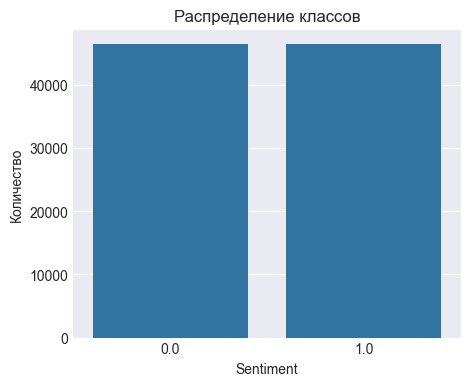

In [27]:
plt.figure(figsize=(5,4))
sns.countplot(x='sentiment', data=df)
plt.title("Распределение классов")
plt.xlabel("Sentiment")
plt.ylabel("Количество")
plt.show()

ну очень равномерно - мы постарались))

Теперь распределение слов:

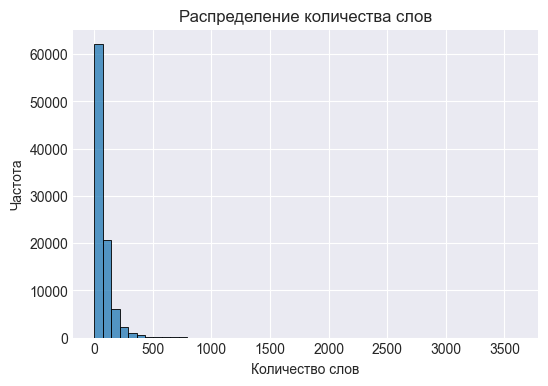

In [30]:
plt.figure(figsize=(6,4))
sns.histplot(df['word_count'], bins=50, kde=False)
plt.title("Распределение количества слов")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.show()

Тут явно какой-то хвост!

In [40]:
df.word_count.value_counts().sort_index().tail(100)

word_count
689     1
690     1
695     4
696     1
697     1
       ..
1474    1
1555    1
1566    1
1741    1
3608    1
Name: count, Length: 100, dtype: int64

Вот так наглядно видно, что у нас с >600 слов идут отдельные кейсы с огромным контекстом, но их ничтожно мало по сравнению с общей выборкой

Посмотрим боксплот количества слов по классам:

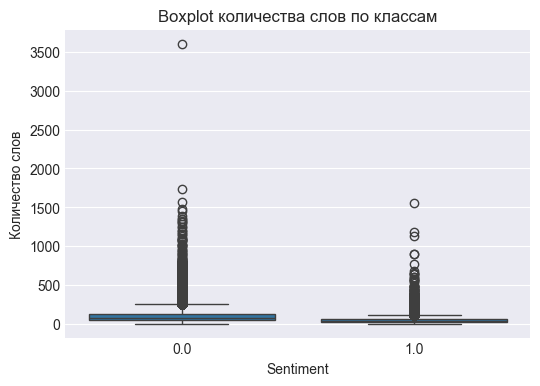

In [36]:
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title("Boxplot количества слов по классам")
plt.xlabel("Sentiment")
plt.ylabel("Количество слов")
plt.show()

В целом визуализация (на мой взгляд не оч удачная) как раз того, что мы подметили выше - отдельные значения резко выбиваются из общей картины для всех кейсов

Глянем распределение количества предложений

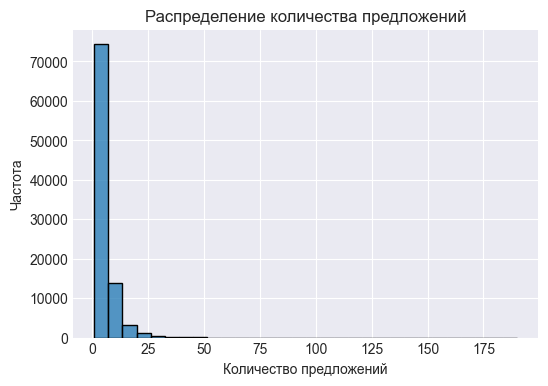

In [37]:
plt.figure(figsize=(6,4))
sns.histplot(df['sentence_count'], bins=30, kde=False)
plt.title("Распределение количества предложений")
plt.xlabel("Количество предложений")
plt.ylabel("Частота")
plt.show()

Тут похоже что-то похожее, глянем датафрейм

In [42]:
df.sentence_count.value_counts().sort_index().tail(30)

sentence_count
50     3
51     1
52     3
53     4
54     2
55     1
56     3
57     1
58     4
59     2
61     2
62     1
64     1
65     2
66     2
67     3
69     1
70     2
75     1
76     1
77     1
79     2
83     1
85     1
90     1
91     1
93     2
122    1
152    2
190    1
Name: count, dtype: int64

Ага, снова очень мало кейсов на больших значениях

Как длина текста коррелирует с sentiment?

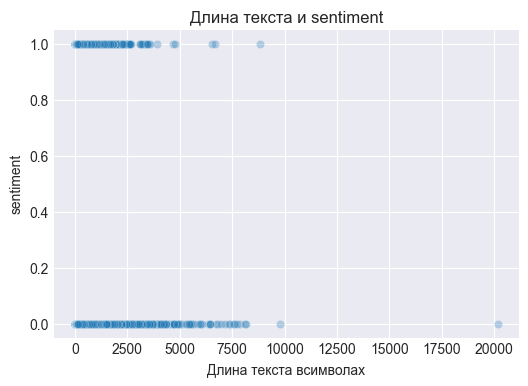

In [43]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='text_length', y='sentiment', data=df, alpha=0.3)
plt.title("Длина текста и sentiment")
plt.xlabel("Длина текста всимволах")
plt.ylabel("sentiment")
plt.show()

В целом на взгляд кажется, что плохие отзывы подлиннее. Может это и логично!

И теперь посмотрим на среднюю длину слова

In [ ]:
# сначала создадим столбец, чтобы было над чем работать!

In [47]:
df['avg_word_length'] = df['text'].progress_apply(
    lambda x: np.mean(
        [len(w) for w in word_tokenize(str(x))]
        )
        if len(word_tokenize(str(x))) > 0
        else 0
)

  0%|          | 0/92878 [00:00<?, ?it/s]

In [48]:
df.head(2)

,address,name_ru,rating,rubrics,text,sentiment,text_length,word_count,sentence_count,avg_word_length
441725,"Москва, улица Сущёвский Вал, 62",Почта банк,5,Банк;Точка банковского обслуживания,Быстро работают. Если очередь стараются быстро...,1.0,77,13,3,5.230769
305909,"Москва, Садовая-Кудринская улица, 15",Детская городская клиническая больница имени Н...,2,Детская больница,"У меня претензия не к качеству исследования, а...",0.0,415,74,5,4.837838


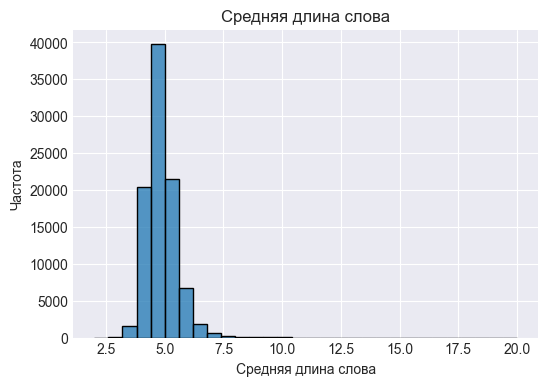

In [49]:
plt.figure(figsize=(6,4))
sns.histplot(df['avg_word_length'], bins=30, kde=False)
plt.title("Средняя длина слова")
plt.xlabel("Средняя длина слова")
plt.ylabel("Частота")
plt.show()

Логично, средние слова в целом небольшие. Даже мои слова здесь вполне небольшие) Нужно постараться чтобы написать в нормальном тексте что-то вроде "обороноспособности"

-----

## **2. Предобработка текста**

На этом этапе мы создадим функцию для полной предобработки текстовых данных.  

- Напишите функцию, выполняющую лемматизацию, удаление стоп-слов, знаков препинания и приведение к нижнему регистру.  
- Примените функцию для создания колонки с обработанным текстом.   
- Проведите частотный анализ слов и визуализируйте облака слов для позитивных и негативных классов.  
- Разделите данные на обучающую, валидационную и тестовую выборки.  


> На всякий случай сделаем бэкап, чтобы было не обидно потерять файлик)

In [52]:
df.to_csv('backup/backup_df.csv', encoding='utf-8', sep=';', index=False)

> С `nltk` я замучился!!! Только костыль в виде `data.path.insert` и `language='russian'` помог решить `LookupError` 😭😭😭
>
> И как к слову с такими багами "не пользоваться LLM"? Мне кажется риторический вопрос

In [73]:
#nltk.download('popular', download_dir=r"e:")
nltk.download('punkt_tab', download_dir=r"e:\nltk_data")

[nltk_data] Downloading package punkt_tab to e:\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [ ]:
#nltk.data.path.append(r"e:\nltk_data")
nltk.data.path.insert(0, r"e:\nltk_data")

In [84]:
print(nltk.data.path)

['e:\\nltk_data', 'C:\\Users\\user/nltk_data', 'f:\\pycode25\\mipt-masters\\nlp\\hws\\hw_1\\.venv\\nltk_data', 'f:\\pycode25\\mipt-masters\\nlp\\hws\\hw_1\\.venv\\share\\nltk_data', 'f:\\pycode25\\mipt-masters\\nlp\\hws\\hw_1\\.venv\\lib\\nltk_data', 'C:\\Users\\user\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data', 'e:\\nltk_data']


In [108]:
morph = pymorphy3.MorphAnalyzer()


def preprocess_text(text,
                    language='russian',
                    use_lemmatization=True,
                    remove_stopwords=True,
                    min_word_length=2):
    """
    Полный pipeline предобработки текста.
    """
    # ЗАДАНИЕ: Реализуйте шаги предобработки:
    # 1. Приведение к нижнему регистру
    # 2. Удаление HTML и URLs
    # 3. Удаление спецсимволов
    # 4. Удаление лишних пробелов
    # 5. Токенизация
    # 6. Удаление стоп-слов
    # 7. Лемматизация
    # 8. Фильтрация по длине слова

    text = str(text).lower()

    # буду честен: re-шки мне подсказала LLMка,
    #   я и в Сбере на работе их всегда через нейронки генерирую 😅
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^а-яёa-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text, language=language)

    if remove_stopwords:
        tokens = [w for w in tokens if w not in stop_words_ru]
    
    if use_lemmatization:
        tokens = [morph.parse(w)[0].normal_form for w in tokens]
    
    tokens = [w for w in tokens if len(w) >= min_word_length]

    return ' '.join(tokens)

In [106]:
# ЗАДАНИЕ: Примените вашу функцию к столбцу 'text' и создайте новый столбец 'processed_text'.
# df['processed_text'] = ...

In [109]:
df['processed_text'] = df['text'].progress_apply(preprocess_text)

  0%|          | 0/92878 [00:00<?, ?it/s]

In [110]:
# Анализ результатов предобработки
print("\nЭффект предобработки:")
print(f"Средняя длина до обработки: {df['word_count'].mean():.1f} слов")
print(f"После полной обработки: {df['processed_text'].str.split().str.len().mean():.1f} слов")


Эффект предобработки:
Средняя длина до обработки: 73.1 слов
После полной обработки: 39.1 слов


In [111]:
# ЗАДАНИЕ: Проведите частотный анализ слов и создайте облака слов для позитивных и негативных отзывов.

In [113]:
pos_texts = df[df['sentiment'] == 1]['processed_text']
neg_texts = df[df['sentiment'] == 0]['processed_text']


In [114]:
pos_all = " ".join(pos_texts)
neg_all = " ".join(neg_texts)

In [115]:
pos_counts = Counter(pos_all.split())
neg_counts = Counter(neg_all.split())

In [116]:
print("Топ-10 слов (позитивные):", pos_counts.most_common(10))

Топ-10 слов (позитивные): [('очень', 29661), ('хороший', 14308), ('место', 10884), ('персонал', 9794), ('отличный', 9363), ('это', 8477), ('спасибо', 7992), ('магазин', 7421), ('вкусный', 7270), ('рекомендовать', 7114)]


In [117]:
print("Топ-10 слов (негативные):", neg_counts.most_common(10))

Топ-10 слов (негативные): [('это', 27806), ('очень', 16036), ('который', 14834), ('сказать', 13744), ('такой', 11826), ('день', 11467), ('просто', 11233), ('человек', 10168), ('время', 9993), ('место', 9484)]


Такс, теперь построим облачка:

In [118]:
wordcloud_pos = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Greens').generate(pos_all)

In [119]:
wordcloud_neg = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Reds').generate(neg_all)

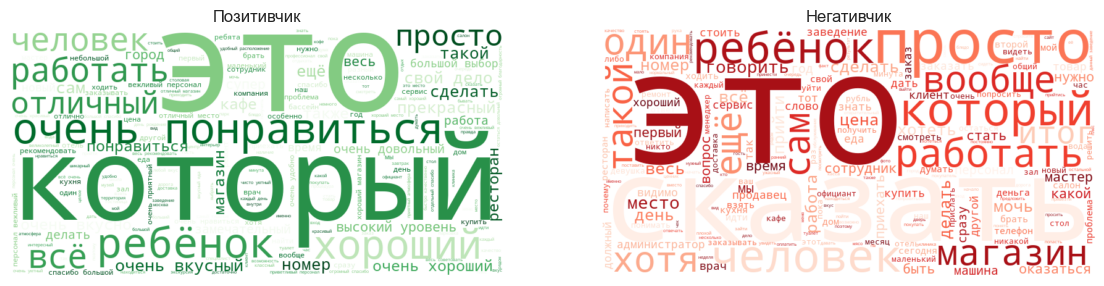

In [120]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Позитивчик")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Негативчик")

plt.show()

> Снова делаем бэкап, теперь уже на ночь

In [121]:
df.to_csv('backup/backup_df_210925.csv', encoding='utf-8', sep=';', index=False)

> Возвращаем датасет:

In [2]:
df = pd.read_csv('backup/backup_df_210925.csv', encoding='utf-8', sep=';')

In [3]:
df.head(1)

,address,name_ru,rating,rubrics,text,sentiment,text_length,word_count,sentence_count,avg_word_length,processed_text
0,"Москва, улица Сущёвский Вал, 62",Почта банк,5,Банк;Точка банковского обслуживания,Быстро работают. Если очередь стараются быстро...,1.0,77,13,3,5.230769,быстро работать очередь стараться быстро обслу...


In [4]:
df.shape

(92878, 11)

-----

## **3. TF-IDF + LogisticRegression**

Векторизуем текст с помощью TF-IDF и обучим модель логистической регрессии.

- Подберите оптимальные параметры TfidfVectorizer (например, max_features, ngram_range), оценивая F1-score на валидационной выборке.  
- Обучите LogisticRegression на лучших TF-IDF признаках.  
- Оцените итоговое качество на тестовой выборке. Выведите отчет с метриками и confusion matrix.  
- Проанализируйте важность признаков (коэффициенты модели).  


In [5]:
# Разделение данных на обучающую, валидационную и тестовую выборки
X = df['processed_text']
y = df['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [6]:
# ЗАДАНИЕ: Проведите эксперименты с различными параметрами TfidfVectorizer (max_features, ngram_range и т.д.).
# Обучите LogisticRegression на каждой конфигурации и выберите лучшую по метрике F1 на валидационной выборке.
# tfidf_params = [...]
# for params in tfidf_params:
#     ...

Прикинем типичные параметры TF-IDF:

In [7]:
tfidf_params = [
    {"max_features": 5000, "ngram_range": (1,1)},
    {"max_features": 10000, "ngram_range": (1,1)},
    {"max_features": 10000, "ngram_range": (1,2)},
    {"max_features": 20000, "ngram_range": (1,2)},
    {"max_features": 30000, "ngram_range": (1,3)}
]

In [8]:
results = []

for params in tfidf_params:
    print()
    print("Пробуем параметры:", params)

    # 1. веткоризируем
    vectorizer = TfidfVectorizer(max_features=params["max_features"],
                                 ngram_range=params["ngram_range"])
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec   = vectorizer.transform(X_val)

    # 2. обучаем
    model = LogisticRegression(max_iter=200, random_state=42)
    model.fit(X_train_vec, y_train)

    # 3. предсказываем
    y_val_pred = model.predict(X_val_vec)

    # 4. чекаем метрику
    f1 = f1_score(y_val, y_val_pred)
    print("F1 на валидации:", f1)

    results.append((params, f1))


Пробуем параметры: {'max_features': 5000, 'ngram_range': (1, 1)}
F1 на валидации: 0.9435321233074042

Пробуем параметры: {'max_features': 10000, 'ngram_range': (1, 1)}
F1 на валидации: 0.9440841619829947

Пробуем параметры: {'max_features': 10000, 'ngram_range': (1, 2)}
F1 на валидации: 0.9471333909536157

Пробуем параметры: {'max_features': 20000, 'ngram_range': (1, 2)}
F1 на валидации: 0.9471787850399942

Пробуем параметры: {'max_features': 30000, 'ngram_range': (1, 3)}
F1 на валидации: 0.9470193901823686


In [9]:
best_params, best_f1 = max(results, key=lambda x: x[1])

print("Лучшие параметры:", best_params)
print("Лучший F1:", best_f1)

Лучшие параметры: {'max_features': 20000, 'ngram_range': (1, 2)}
Лучший F1: 0.9471787850399942


In [10]:
# Финальная оценка лучшей модели на тестовой выборке
# best_vectorizer = ...
# best_lr_model = ...
# X_test_tfidf = best_vectorizer.transform(X_test)
# y_test_pred_tfidf = best_lr_model.predict(X_test_tfidf)

In [11]:
X_trainval = pd.concat([X_train, X_val])

y_trainval = pd.concat([y_train, y_val])

Используем найденные оптимальные параметры:

In [12]:
best_vectorizer = TfidfVectorizer(max_features=best_params["max_features"],
                                  ngram_range=best_params["ngram_range"])

In [13]:
X_trainval_tfidf = best_vectorizer.fit_transform(X_trainval)

In [14]:
X_test_tfidf = best_vectorizer.transform(X_test)

In [15]:
best_lr_model = LogisticRegression(max_iter=200)

In [16]:
best_lr_model.fit(X_trainval_tfidf, y_trainval)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


Предскажем!

In [17]:
y_test_pred = best_lr_model.predict(X_test_tfidf)

In [18]:
y_test_prob = best_lr_model.predict_proba(X_test_tfidf)[:, 1]

In [19]:
# ЗАДАНИЕ: Рассчитайте и выведите метрики (Accuracy, Precision, Recall, F1, ROC_AUC) и confusion matrix.
# ...

In [20]:
acc = accuracy_score(y_test, y_test_pred)

prec = precision_score(y_test, y_test_pred)

rec = recall_score(y_test, y_test_pred)

f1 = f1_score(y_test, y_test_pred)

roc_auc = roc_auc_score(y_test, y_test_prob)

In [21]:
print("Accuracy:", acc)
print("Пресижн:", prec)
print("Recall:", rec)
print("F 1:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.9468848693654895
Пресижн: 0.951683110853163
Recall: 0.9415733563020384
F 1: 0.9466012411603406
ROC AUC: 0.9840721583666829


In [22]:
cm = confusion_matrix(y_test, y_test_pred)

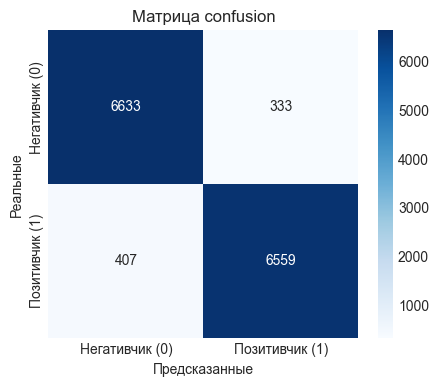

In [23]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Негативчик (0)','Позитивчик (1)'],
            yticklabels=['Негативчик (0)','Позитивчик (1)'])
plt.xlabel("Предсказанные")
plt.ylabel("Реальные")
plt.title("Матрица confusion")
plt.show()


In [24]:
# Анализ важности признаков
# ...

In [25]:
feature_names = best_vectorizer.get_feature_names_out()
coeffs = best_lr_model.coef_[0]

Возьмём 10-топ позитивных и негативных

In [26]:
top_pos = sorted(zip(coeffs, feature_names), reverse=True)[:10]
top_neg = sorted(zip(coeffs, feature_names))[:10]

In [27]:
print("Топ-10 слов для позитивных отзывов:")
for coef, word in top_pos:
    print(word, round(coef, 1))

Топ-10 слов для позитивных отзывов:
отличный 10.6
спасибо 9.5
хороший 8.4
быстро 7.2
отлично 6.8
вежливый 6.4
прекрасный 6.2
замечательный 5.9
довольный 5.8
приятный 5.7


In [28]:
print("Топ-10 слов для негативных отзывов:")
for coef, word in top_neg:
    print(word, round(coef, 1))

Топ-10 слов для негативных отзывов:
отвратительный -10.1
ужасный -10.1
итог -6.3
грязный -6.1
деньга -6.0
испортить -5.9
ужас -5.9
никто -5.5
вообще -4.9
ужасно -4.8


> "Итог" - в топ-негативе! Интересно, видимо потому что слово используют как "приговор" фильму 🙄

In [29]:
# Сохранение лучшей модели
# with open('models/tfidf_lr.pkl', 'wb') as f:
#     pickle.dump(best_lr_model, f)

In [30]:
with open('models/tfidf_lr.pkl', 'wb') as f:
    pickle.dump((best_vectorizer, best_lr_model), f)

-----

## **4. Word2Vec embeddings**

Теперь используем Word2Vec для получения векторных представлений текста.

- Обучите собственную модель Word2Vec на обучающей выборке. Подберите оптимальные параметры (vector_size, window, sg), оценивая F1-score классификатора на валидации.  
- Реализуйте функцию получения вектора документа путем усреднения векторов слов.
- Обучите LogisticRegression на полученных векторах.
- Оцените качество на тестовой выборке.

In [31]:
# Подготовка данных для Word2Vec
tokenized_texts = [text.split() for text in df['processed_text']]

In [32]:
# ЗАДАНИЕ: Проведите эксперименты с параметрами Word2Vec (vector_size, window, sg).
# Для каждого набора параметров векторизуйте тексты (усредняя векторы слов) и обучите LogisticRegression.
# Выберите лучшую модель по F1 на валидации.
# w2v_params = [...]
# for params in w2v_params:
#     ...

In [33]:
X_train_tok = [t.split() for t in X_train]
X_val_tok = [t.split() for t in X_val]
X_test_tok = [t.split() for t in X_test]

Выберем снова параметры для экспериментов:

In [34]:
w2v_params = [
    {"vector_size": 100, "window": 5, "sg": 0},
    {"vector_size": 100, "window": 5, "sg": 1},
    {"vector_size": 200, "window": 5, "sg": 1},
    {"vector_size": 300, "window": 10, "sg": 1}
]

In [35]:
def vectorize_texts(tokenized, model, vector_size):
    """Усредняем вектора слов - доп.функция"""
    vectors = []
    for tokens in tokenized:
        word_vecs = [model.wv[w] for w in tokens if w in model.wv]
        if len(word_vecs) > 0:
            vectors.append(np.mean(word_vecs, axis=0))
        else:
            vectors.append(np.zeros(vector_size))
    return np.array(vectors)

In [36]:
results = []

for params in w2v_params:
    print("Тестим параметры:", params)
    
    # обучаем
    w2v_model = Word2Vec(
        sentences=X_train_tok,
        vector_size=params["vector_size"],
        window=params["window"],
        sg=params["sg"],
        min_count=2,
        workers=4
        )
    
    # векторизируем
    X_train_vec = vectorize_texts(X_train_tok, w2v_model, params["vector_size"])
    X_val_vec = vectorize_texts(X_val_tok, w2v_model, params["vector_size"])
    
    # логрегрессия
    clf = LogisticRegression(max_iter=200, random_state=42)
    clf.fit(X_train_vec, y_train)
    
    y_val_pred = clf.predict(X_val_vec)
    f1 = f1_score(y_val, y_val_pred)
    
    print("F1 на валидации:", f1)
    
    results.append((params, f1, w2v_model, clf))

Тестим параметры: {'vector_size': 100, 'window': 5, 'sg': 0}
F1 на валидации: 0.9304719785398391
Тестим параметры: {'vector_size': 100, 'window': 5, 'sg': 1}
F1 на валидации: 0.9357612544258979
Тестим параметры: {'vector_size': 200, 'window': 5, 'sg': 1}
F1 на валидации: 0.9399017624963883
Тестим параметры: {'vector_size': 300, 'window': 10, 'sg': 1}
F1 на валидации: 0.9427808644202323


In [37]:
best_params, best_f1, best_w2v, best_clf = max(results, key=lambda x: x[1])

In [38]:
print("Лучшие параметры:", best_params)
print('Лучший F 1:', best_f1)

Лучшие параметры: {'vector_size': 300, 'window': 10, 'sg': 1}
Лучший F 1: 0.9427808644202323


In [39]:
# Финальная оценка лучшей модели
# ...

In [40]:
X_test_vec = vectorize_texts(X_test_tok, best_w2v, best_params["vector_size"])
y_test_pred = best_clf.predict(X_test_vec)

In [41]:
final_f1 = f1_score(y_test, y_test_pred)

In [42]:
print("F 1 на тесте:", final_f1)

F 1 на тесте: 0.9442679757435749


In [43]:
# ЗАДАНИЕ: Рассчитайте метрики и выведите confusion matrix.
# ...

# Анализ семантических отношений (найти похожие слова)
# ...

# Сохранение лучшей модели
# ...

In [44]:
y_test_prob = best_clf.predict_proba(X_test_vec)[:,1]

acc = accuracy_score(y_test, y_test_pred)

prec = precision_score(y_test, y_test_pred)

rec = recall_score(y_test, y_test_pred)

f1 = f1_score(y_test, y_test_pred)

roc_auc = roc_auc_score(y_test, y_test_prob)

In [45]:
print("Accuracy:", acc)

print("Пресижн:", prec)

print("Recall:", rec)

print("F 1:", f1)

print("ROC AUC:", roc_auc)

Accuracy: 0.9445879988515647
Пресижн: 0.949753122277084
Recall: 0.9388458225667528
F 1: 0.9442679757435749
ROC AUC: 0.9826286596585077


Посмотрим матрицу

In [46]:
cm = confusion_matrix(y_test, y_test_pred)

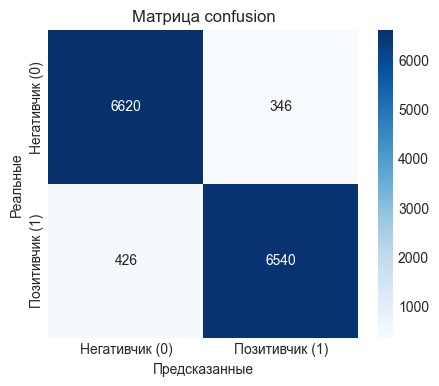

In [47]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Негативчик (0)','Позитивчик (1)'],
            yticklabels=['Негативчик (0)','Позитивчик (1)'])
plt.xlabel("Предсказанные")
plt.ylabel("Реальные")
plt.title("Матрица confusion")
plt.show()

Ещё лучше чем в прошлой!

Анализ семантических отношений по похожим словам

In [48]:
for word in ["фильм", "очередь", "хороший", "плохой"]:
    if word in best_w2v.wv:
        print(f"Слово: {word}")
        print(best_w2v.wv.most_similar(word, topn=5))
    else:
        print(f"Слово '{word}' отсутствует в словаре модели")

Слово: фильм
[('мультфильм', 0.6792129874229431), ('сериал', 0.6678184270858765), ('кино', 0.6582576632499695), ('аватар', 0.6545781493186951), ('чебурашка', 0.651426374912262)]
Слово: очередь
[('nочередь', 0.6463240385055542), ('отстоять', 0.6346166133880615), ('выстраиваться', 0.6167380809783936), ('талончик', 0.6067474484443665), ('стояние', 0.5949608087539673)]
Слово: хороший
[('приветлевый', 0.699360728263855), ('nдоступный', 0.6988555788993835), ('суперский', 0.6976418495178223), ('отличный', 0.6913768649101257), ('экстра', 0.6910446286201477)]
Слово: плохой
[('тамбов', 0.5529148578643799), ('ужасный', 0.5353254675865173), ('отстойный', 0.5241129398345947), ('ужастный', 0.5213772654533386), ('nужасный', 0.5153323411941528)]


> `Слово: плохой`
> 
> ```[('тамбов', 0.5529148578643799), ('ужасный', 0.5353254675865173), ('отстойный', 0.5241129398345947), ('ужастный', 0.5213772654533386)]```
>
> ТАМБОВ 😹😹😹 Ну, алгоритмам виднее

Сохраним модельку:

In [49]:
best_w2v.save("models/best_word2vec.model")

и классификатор:

In [50]:
with open("models/word2vec_lr.pkl", "wb") as f:
    pickle.dump(best_clf, f)

-----

## **5. FastText embeddings**

Обучим модель FastText и сравним ее с Word2Vec.

- Обучите модель FastText.
- По аналогии с Word2Vec, получите векторы документов и обучите классификатор.
- Оцените качество на тестовой выборке.
- Продемонстрируйте преимущество FastText на OOV-словах (словах, отсутствующих в словаре).


In [51]:
# ЗАДАНИЕ: Обучите модель FastText с параметрами по вашему выбору.
# fasttext_model = ...

# Векторизация и обучение классификатора
# ...

In [52]:
X_train_tok = [t.split() for t in X_train]
X_val_tok   = [t.split() for t in X_val]
X_test_tok  = [t.split() for t in X_test]

In [53]:
fasttext_model = FastText(
    sentences=X_train_tok,
    vector_size=100,
    window=5,
    sg=1,
    min_count=2,
    workers=4
)

Снова оформим функцию по усреднению

In [54]:
def vectorize_texts(tokenized, model, vector_size):
    """Усредняем слова"""
    vectors = []
    for tokens in tokenized:
        word_vecs = [model.wv[w] for w in tokens if w in model.wv]
        if len(word_vecs) > 0:
            vectors.append(np.mean(word_vecs, axis=0))
        else:
            vectors.append(np.zeros(vector_size))
    return np.array(vectors)

In [55]:
X_train_vec = vectorize_texts(X_train_tok, fasttext_model, 100)
X_val_vec   = vectorize_texts(X_val_tok, fasttext_model, 100)
X_test_vec  = vectorize_texts(X_test_tok, fasttext_model, 100)

Обучаем модельку

In [56]:
clf = LogisticRegression(max_iter=200)

clf.fit(X_train_vec, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [57]:
y_val_pred = clf.predict(X_val_vec)

In [58]:
f1 = f1_score(y_val, y_val_pred)

print("F 1 на валидации:", f1)

F 1 на валидации: 0.9375045155696843


In [59]:
# ЗАДАНИЕ: Оцените модель на тестовой выборке (метрики и confusion matrix).
# ...

# Тест на OOV (out-of-vocabulary) словах и сравнение с Word2Vec
# ...

# Сохранение модели
# ...

In [60]:
y_test_pred = clf.predict(X_test_vec)

y_test_prob = clf.predict_proba(X_test_vec)[:,1]

In [61]:
acc = accuracy_score(y_test, y_test_pred)

prec = precision_score(y_test, y_test_pred)

rec = recall_score(y_test, y_test_pred)

f1 = f1_score(y_test, y_test_pred)

roc_auc = roc_auc_score(y_test, y_test_prob)

In [62]:
print("Accuracy:", acc)

print("Пресижн:", prec)

print("Recall:", rec)

print("F 1:", f1)

print("ROC AUC:", roc_auc)

Accuracy: 0.9402813666379558
Пресижн: 0.946044211751018
Recall: 0.9338214183175424
F 1: 0.9398930790348216
ROC AUC: 0.9804678010720872


Снова строим матрицу

In [63]:
cm = confusion_matrix(y_test, y_test_pred)

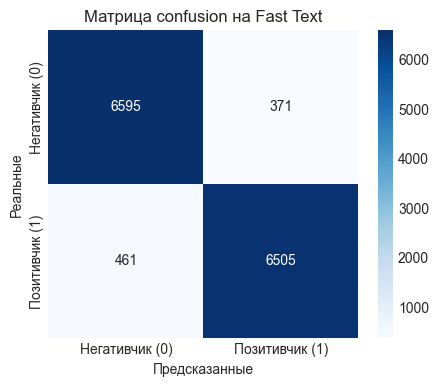

In [64]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Негативчик (0)','Позитивчик (1)'],
            yticklabels=['Негативчик (0)','Позитивчик (1)'])
plt.xlabel("Предсказанные")
plt.ylabel("Реальные")
plt.title("Матрица confusion на Fast Text")
plt.show()

Как будто у word 2 vec получше было... 

Протестим теперь на словах мне словаря

In [65]:
test_words = ["суперпупербанк", "неизвестнословие", "сасный", "кринжовник"]

In [66]:

for w in test_words:
    if w in fasttext_model.wv:
        print(f"{w}: FastText вектор найден (размер {len(fasttext_model.wv[w])})")
    else:
        print(f"{w}: FastText не знает")

суперпупербанк: FastText вектор найден (размер 100)
неизвестнословие: FastText вектор найден (размер 100)
сасный: FastText вектор найден (размер 100)
кринжовник: FastText вектор найден (размер 100)


Опа, глянем насколько слова близкие по смыслу

In [67]:
for w in test_words:
    print(f"Рассмотрим слово: {w}")
    if w in fasttext_model.wv:
        similar_words = fasttext_model.wv.most_similar(w, topn=5)
        for sim_word, score in similar_words:
            print(f"> > > {sim_word} ({round(score, 3)})")

Рассмотрим слово: суперпупербанк
> > > суперб (0.885)
> > > супермен (0.883)
> > > супермакет (0.861)
> > > суперскай (0.859)
> > > суперррр (0.854)
Рассмотрим слово: неизвестнословие
> > > неизвестность (0.907)
> > > неизвестно (0.868)
> > > неизвестный (0.854)
> > > dfm (0.839)
> > > дду (0.839)
Рассмотрим слово: сасный
> > > часный (0.94)
> > > сный (0.915)
> > > прекоасный (0.893)
> > > класный (0.893)
> > > nкрасный (0.881)
Рассмотрим слово: кринжовник
> > > клоповник (0.908)
> > > шиповник (0.883)
> > > чиновник (0.88)
> > > полковник (0.875)
> > > штангенциркуль (0.866)


Хаххах ну "класный" в чём-то похоже по смыслу на "сасный" 😅

В целом тяжело конечно найти смысл, но хоть пытается

Сравним с Word2Vec!

In [68]:
for w in test_words:
    if w in best_w2v.wv:
        print(f"{w}: Word2Vec вектор найден")
    else:
        print(f"{w}: Word2Vec OOV (не знает слово)")

суперпупербанк: Word2Vec OOV (не знает слово)
неизвестнословие: Word2Vec OOV (не знает слово)
сасный: Word2Vec OOV (не знает слово)
кринжовник: Word2Vec OOV (не знает слово)


Word2Vec в этом плане проигрывает, даже не находит варианты. Жаль!

-----

## **6. Отчеты и выводы**
### **6.1. Визуализация и анализ**

Сравним все полученные модели и визуализируем результаты.

- Подготовьте сводную таблицу и/или график со сравнительными метриками всех моделей.
- Визуализируйте эмбеддинги с помощью t-SNE.
- Проанализируйте ошибки моделей.


In [69]:
# ЗАДАНИЕ: Создайте сравнительную таблицу и графики для метрик всех моделей.
# Постройте общую ROC-кривую.
# ...

# t-SNE визуализация эмбеддингов
# (Используйте эмбеддинги лучшей модели Word2Vec или FastText)
# ...

# Анализ ошибок
# (Найдите примеры текстов, на которых все модели ошибаются)
# ...

> Блин, тут я тупанул. Я-то метрики перезаписывал, и надо их будет снова рассчитать 😕
>
> Очередной урок на будущее: перед работой нужно оценить все задачи, и исходя из этого писать код 

In [70]:
X_test_tfidf = best_vectorizer.transform(X_test)
y_pred_tfidf = best_lr_model.predict(X_test_tfidf)
y_prob_tfidf = best_lr_model.predict_proba(X_test_tfidf)[:, 1]

In [71]:
X_test_vec_w2v = vectorize_texts(X_test_tok, best_w2v, best_params["vector_size"])
y_pred_w2v = best_clf.predict(X_test_vec_w2v)
y_prob_w2v = best_clf.predict_proba(X_test_vec_w2v)[:, 1]

In [72]:
clf_ft = clf

X_test_vec_ft = vectorize_texts(X_test_tok, fasttext_model, fasttext_model.vector_size)

y_pred_ft = clf_ft.predict(X_test_vec_ft)
y_prob_ft = clf_ft.predict_proba(X_test_vec_ft)[:, 1]


Вроде не напутали и создали новые объекты. Будем рассчитывать

In [73]:
def calc_all_metrics(y_true, y_pred, y_prob):
    """Рассчитываем метрики под конкретное предсказание"""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_prob)
    }

In [74]:
metrics_tfidf = calc_all_metrics(y_test, y_pred_tfidf, y_prob_tfidf)
metrics_w2v = calc_all_metrics(y_test, y_pred_w2v, y_prob_w2v)
metrics_ft = calc_all_metrics(y_test, y_pred_ft, y_prob_ft)

In [75]:
summary_df = pd.DataFrame.from_dict(
    {
        "TF-IDF": metrics_tfidf,
        "Word2Vec": metrics_w2v,
        "FastText": metrics_ft
    },
    orient="index"
).round(4)

In [76]:
summary_df

,Accuracy,Precision,Recall,F1,ROC_AUC
TF-IDF,0.9469,0.9517,0.9416,0.9466,0.9841
Word2Vec,0.9446,0.9498,0.9388,0.9443,0.9826
FastText,0.9403,0.9460,0.9338,0.9399,0.9805


Fast Text казалось бы по метрикам похуже остальных, но зато гибкий!

<Figure size 800x500 with 0 Axes>

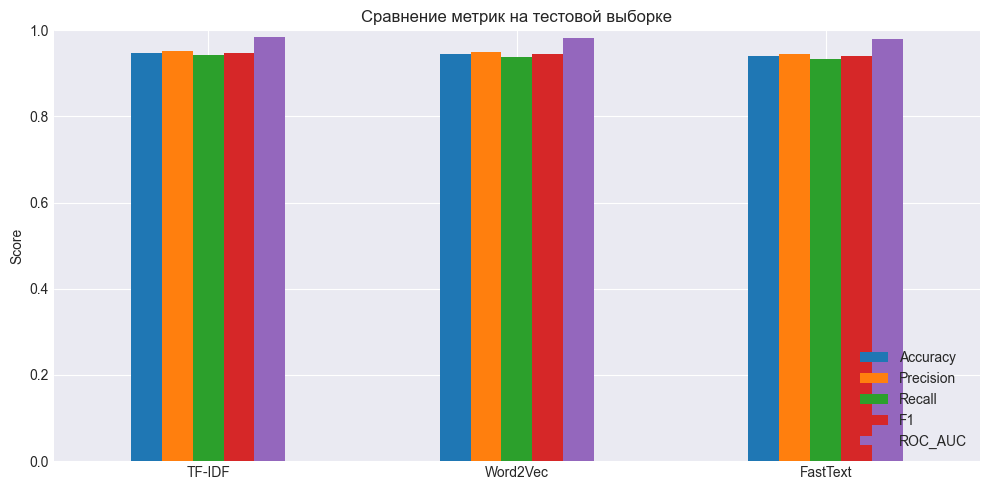

In [77]:
plt.figure(figsize=(8,5))

summary_df[["Accuracy","Precision","Recall","F1","ROC_AUC"]].plot(kind="bar", figsize=(10,5))

plt.title("Сравнение метрик на тестовой выборке")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()

plt.show()


Глянем теперь ROC-кривую

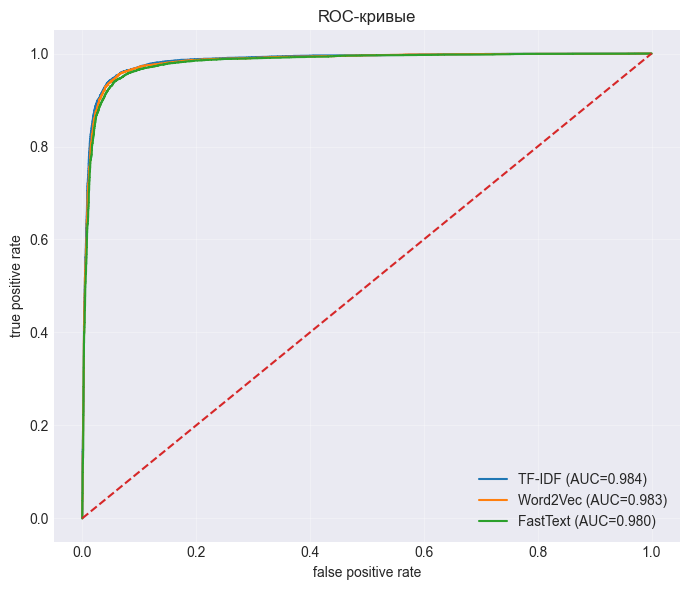

In [78]:
plt.figure(figsize=(7,6))

for name, y_prob in [
    ("TF-IDF", y_prob_tfidf),
    ("Word2Vec", y_prob_w2v),
    ("FastText", y_prob_ft),
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")


plt.plot([0,1],[0,1], linestyle="--")

plt.title("ROC-кривые")

plt.xlabel("false positive rate")

plt.ylabel("true positive rate")

plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

Не то чтобы график очень интуитивный - все наши модели очень похожи

Теперь посмотрим на визуализацию эмбеддингов

In [79]:
f1_w2v_test = f1_score(y_test, y_pred_w2v)

f1_ft_test  = f1_score(y_test, y_pred_ft)

In [80]:
use_model = "w2v" if f1_w2v_test >= f1_ft_test else "ft"

In [81]:
print(f"Для t-SNE берём: {use_model.upper()} (F1_w2v={f1_w2v_test:.3f}, F1_ft={f1_ft_test:.3f})")

Для t-SNE берём: W2V (F1_w2v=0.944, F1_ft=0.940)


In [82]:
X_tsne_source = X_test_vec_w2v

In [83]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca")

X_tsne_2d = tsne.fit_transform(X_tsne_source)

In [84]:
tsne_df = pd.DataFrame({
    "x": X_tsne_2d[:,0],
    "y": X_tsne_2d[:,1],
    "label": y_test.values
})

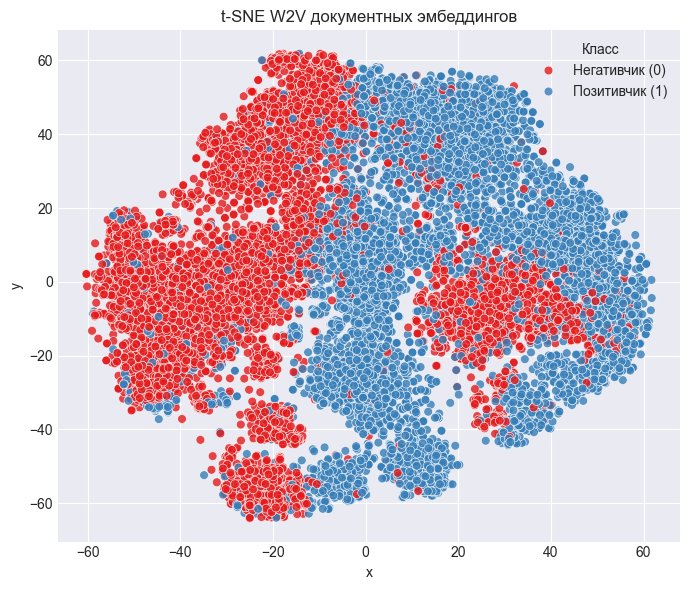

In [85]:
plt.figure(figsize=(7,6))

ax = sns.scatterplot(
    data=tsne_df,
    x="x", y="y",
    hue="label",
    palette="Set1",
    s=40, alpha=0.8
)

plt.title(f"t-SNE {use_model.upper()} документных эмбеддингов")

handles, labels = ax.get_legend_handles_labels()

new_labels = ["Негативчик (0)", "Позитивчик (1)"]
plt.legend(handles=handles, labels=new_labels, title="Класс")

plt.tight_layout()
plt.show()

Перейдём к самой интересной части - какие отзывы не смогли классифицировать все модели?

In [86]:
test_index = X_test.index


mis_tfidf = (y_pred_tfidf != y_test.values)
mis_w2v = (y_pred_w2v != y_test.values)
mis_ft = (y_pred_ft != y_test.values)

In [87]:
all_miss_mask = mis_tfidf & mis_w2v & mis_ft

In [88]:
idx_all_miss = test_index[all_miss_mask]
n_show = min(10, len(idx_all_miss))

print(f"Всего общих ошибок: {len(idx_all_miss)}, мы посмотрим {n_show}")

Всего общих ошибок: 506, мы посмотрим 10


In [96]:
examples = []

for i, idx in enumerate(idx_all_miss[:n_show]):
    examples.append({
        "idx": idx,
        'text': df.loc[idx, 'text'],
        "processed_text": df.loc[idx, "processed_text"],
        "true_label": int(y_test.loc[idx]),
        "pred_tfidf": int(y_pred_tfidf[list(test_index).index(idx)]),
        "pred_w2v":   int(y_pred_w2v[list(test_index).index(idx)]),
        "pred_ft":    int(y_pred_ft[list(test_index).index(idx)])
    })

In [98]:
pd.set_option("display.max_colwidth", None)

pd.DataFrame(examples)

,idx,text,processed_text,true_label,pred_tfidf,pred_w2v,pred_ft
0,48569,Не хватает выбора товаров в основном на,хватать выбор товар основное,0,1,1,1
1,36951,"Так а что здесь можно купить. Закуточек для детей, раз зайти. Цены большие. А выбора нет. Лучше спуститься на Сафонова кажется, на площади есть большой магазин, "" Лавка чудес"" там и выбор и \nцены всегда нормальные.",купить закуточка ребёнок зайти цена больший выбор спуститься сафонов казаться площадь большой магазин лавка чудо выбор nцена нормальный,0,1,1,1
2,52989,"Кухня очень и очень не вкусная. Пробовал чебуреки (старые и разогретые), сырники (совсем не вкусные и тоже не свежие), салат мимоза (очень мало рыбы и тоже не вкусно), пельмени (терпимо и за многими заметил, что не доедают), яичница на завтрак (приемлемо, но если брать с колбасой, то она самая дешёвая и не вкусная), чай (тут они молодцы, пакетик нормально заварили). \nХодили по утрам на завтрак и на обед. На завтрак приходили первыми и достаточного быстро всё приготовили. \nВ обед был полный зал и ожидание готовности 40-50 минут. \nК сожалению рядом альтернативы нету и народ туда заходит",кухня очень очень вкусный пробовать чебурек старый разогреть сырник вкусный свежий салат мимоза очень мало рыба вкусно пельмень терпимо многий заметить доедать яичница завтрак приемлемый брать колбаса самый дешёвый вкусный чай молодец пакетик нормально заварить nходить утро завтрак обед завтрак приходить первый достаточный быстро всё приготовить nв обед полный зал ожидание готовность минута nк сожаление рядом альтернатива нету народ туда заходить,0,1,1,1
3,36943,"Мы-постоянные клиенты этого приёмного пункта металлолома !Вызываем у них машину (газель,камаз,смотря какой объем) с грузчками .Приезжают вовремя, деньги сразу и цены всегда выше,чем у остальных!Твёрдая пятёрка им!",постоянный клиент приёмный пункт металлолом вызывать машина газель камаз смотреть объём грузчка приезжать вовремя деньга сразу цена выше остальной твёрдый пятёрка,1,0,0,0
4,26124,"Откройте больше магазинов, доступных для покупателей-ну, нечего в тц купить...ни терволины и ральф-рингера, ни сенсей и золлы, ни снежной королевы и глория джинс. Ашан хорошо, ресторанный дворик-хорошо, туалеты в тц хорошо, кинотеатр хорошо, книжный магазин-безумные цены, леонардо-для больших любителей, хаммлес-не подступиться. Я за новые бюджетные магазины в тц!",открыть магазин доступный покупатель нечего тц купить терволин ральф рингера сенсеять золл снежный королева глория джинс ашан ресторанный дворик туалет тц кинотеатр книжный магазин безумный цена леонардо больший любитель хаммлеса подступиться новый бюджетный магазин тц,0,1,1,1
5,8979,"Природа, ферма, коллектив - это всё правда прекрасно. Но детей с дислексией учить не умеют, хотя заявлено, что сложные дети - это к ним, и в классах по нескольку человек. Никакого индивидуального подхода и помощи в адаптации. Ну и бытовые условия довольно спартанские, мой ребенок привык к походам и поездкам, ему было нормально, городским детям может быть сложно. \nС доступом к медицине в случае чего большие сложности.",природа ферма коллектив это всё правда прекрасно ребёнок дислексия учить уметь хотя заявить сложный ребёнок это класс несколько человек никакой индивидуальный подход помощь адаптация бытовой условие довольно спартанский ребёнок привыкнуть поход поездка нормально городской ребёнок сложно nс доступ медицина случай больший сложность,0,1,1,1
6,19287,Был в этом сквере.нет ни какой скульптуры или композиции. Нет указателей на её нахождение,сквер скульптура композиция указатель её нахождение,0,1,1,1
7,56454,Красиво и уютно люстры плафоны подсветки как дома светло чисто и свежо в магазине комфортно просторно и гармонично атмосферно фантастически,красиво уютный люстра плафон подсветка дом светло чисто свежий магазин комфортно просторно гармонично атмосферный фантастически,0,1,1,1
8,23634,"Новый , красивый клуб. Минусов лично для себя не нашла пока. Есть возможность не дорого и вкусно покушать в кафе. Пока пробовала цезарь, роллы и

В целом видны быстрые гипотезы по общим ошибкам:
- Модели тяжело, когда отзыв комплексный: есть и плюсы, и минусы. Нужно из общего контекста понять, какие конкретно плюсы или минусы перевешивают *(природа прекрасная, но условия спартанские)*
- Есть прямые ошибки: отзыв сугубо положительный, но оценка отрицательная *(Красиво и уютно, комфортно и пространо, атмосфера фантастическая, оценка 2)*
- В чате пишут что сарказм модели тоже не вывозят. Но у нас в семплах отзывы без сарказма

-----

## **6. Отчеты и выводы**
### **6.2. Подготовка отчетов**

Подготовьте итоговый отчет в формате Markdown.

- Проанализируйте ошибки моделей.
- Сформулируйте итоговые выводы (5-8 предложений): какой метод показал себя лучше и почему, в чем преимущества и недостатки каждого подхода, какие дальнейшие шаги по улучшению качества можно предпринять.

In [99]:
# ЗАДАНИЕ: Сгенерируйте отчет, включающий описание данных, шаги предобработки,
# результаты моделей, сравнительный анализ, выводы и рекомендации.
report = f"""
# Отчёт по анализу отзывов

## 1. Данные
У нас были тексты отзывов (негатив/позитив). Всего +- {len(df)} штук.  
Первым делом разбил на train/val/test, чтоб всё честно проверить.
Баланс по классам получился искусственный, но для нашей задачи более-менее норм.

## 2. Предобработка
Тексты почистил: убрал html, ссылки, лишние знаки. Привёл к нижнему регистру + лемматизацию
Сделал токенизацию. Для эмбеддингов (w2v/ft) - сплит по словам
С nltk были проблемы при токенизации, пришлось костылить - см. решение в Параграфе 2

## 3. Модели и результаты
**TF-IDF + логрег**  
- лучшие параметры: {best_params}  
- F1 на тесте: {f1_score(y_test, y_pred_tfidf):.2f}, ROC AUC: {roc_auc_score(y_test, y_prob_tfidf):.2f}

**Word2Vec + логрег**  
- параметры: {best_params}  
- F1 на тесте: {f1_score(y_test, y_pred_w2v):.2f}, ROC AUC: {roc_auc_score(y_test, y_prob_w2v):.2f}

**FastText + логрег**  
- vector_size=100, window=5, sg=1  
- F1 на тесте: {f1_score(y_test, y_pred_ft):.2f}, ROC AUC: {roc_auc_score(y_test, y_prob_ft):.2f}

(таблица и графики см. юпитер ноутбук)

## 4. Ошибки
Все модели валились на:
- коротких/мутных отзывах, 
- эмоционально комплексных отзывах, когда люди писали и плюсы, и минусы
- на ошибочных отзывах (тут неудивительно)  
- по словам одногруппников - на редких словах и сарказме
Интересно было бы проверить на последнем фаст-текст. Но у меня были семплы без редких слов

Примеры общих ошибок есть в ноуте - видно, что смысл неочевидный

## 5. Выводы
1. TF-IDF дал нормальный базовый результат, но семантики не видит.  
2. Word2Vec чуть лучше вытянул F1, ловит смысл слов  
3. FastText классно работает с редкими словами, но общий скор оказался хуже чем у w2v. 
4. Данные тоже не идеальные, см. те же ошибочные разметки, так что хороший шаг - собрать/почистить побольше отзывов
"""

# Сохранение отчета в формате markdown, вы можете использовать также pdf и docx
with open('reports/final_report.md', 'w', encoding='utf-8') as f:
    f.write(report)
print("Отчет сохранен в reports/final_report.md")

Отчет сохранен в reports/final_report.md


Ура, готово! 🎉

-----

## **Дополнительное задание по желанию**

За задание дополнительные баллы не ставятся. Оно выполняется по желанию студента.

In [ ]:
# Примеры бонусных заданий:
# 1. Ансамблирование моделей (усреднение вероятностей).
# 2. Кросс-валидация для более надежной оценки.
# 3. Использование предобученных эмбеддингов (например, из gensim-data).
# 4. Анализ интерпретируемости с LIME.
# 5. Загрузку Word2Vec модели из Семинара 1

Задание интересное, но на него не осталось времени( Подумаю над ним на следующих недельках